<a href="https://colab.research.google.com/github/Smartsie/Optimizer/blob/master/Optimizer_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
""" 
Optim package - T Martin 10 May 2020
This code if for multivariate optimizer using surrogate response surface created by several ML models
The next target point to study is either based on minimum point found, either by using a surrogate if r2 value of 
a model is above a certain threshold
"""

' \nOptim package - T Martin 10 May 2020\nThis code if for multivariate optimizer using surrogate response surface created by several ML models\nThe next target point to study is either based on minimum point found, either by using a surrogate if r2 value of \na model is above a certain threshold\n'

# **Functionnalities to be added**
1.  Make the algorithm work for an arbitrary amount of variables xi [1,2,3,..]
2. Models should be listed in a dictionnary. Each model is defined by it's 
function or class with train, predict and score 
3.   During fitting, we will score all models. The highest score will then be used for the prediction
4. This could be done by doing a voting of top 3 best models with a 3,2,1 weight for instance
5. Models accuracy will evolve with time (DOF)
6. Evaluation of models should be done by X-validation
7. Add early stop 







In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [4]:
import plotly as py
from keras.layers import Dense
import lightgbm
import plotly.express as px

In [184]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
kernel = DotProduct() + WhiteKernel()
model = GaussianProcessRegressor(random_state=0)
import tensorflow.keras
from tensorflow.keras.models import Sequential
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

In [6]:
# If we want to export in html in a separate browser
import plotly.io as pio
#pio.renderers.default = "browser" 

In [7]:
def Japan_map():
  from google.colab import drive
  drive.mount('/content/drive')
  df=pd.read_csv('/content/drive/My Drive/Colab Data/Japan_XYZ_data.txt',header=None,delimiter=r"\s+")
  df.columns=['x0','x1','z']
  # Flip the data in z so that Mt Fuji is minimum
  df['z']=-df['z']
  # Resample the Dataframe to speed things up
  # N=10000 --> we keep only 10000 points
  N=500000
  step=int(len(df)/N)
  DF=df[::step]

  print('Theoretical Minimum:')
  print(DF.iloc[np.argmin(DF.z)])
  minx0=DF.iloc[np.argmin(DF.z)][0]
  minx1=DF.iloc[np.argmin(DF.z)][1]
  return

In [8]:
def eval_f(vector):
  x1std=DF['x0'].std()
  x2std=DF['x1'].std()
  mask1=np.abs(DF['x0']-vector[0])<x1std/4
  mask2=np.abs(DF['x1']-vector[1])<x2std/4
  a=DF[mask1&mask2]
  result=a['z'].min()
  return result

In [241]:
# Define function to minimize
# x is a vector containing what we want to evaluate
def funct(x):
    x1=x[0]
    x2=x[1]
    #f=x1*x1+x1*x2+2*np.sin((x1+x2)*2)+4*np.cos(x2*2)
    #f=x1*x1+x2*x2-x1*x2+20*np.sin(x1-x2)-8*np.cos(x2*2)
    #f=(x1-3)*(x1-3)+(x2-1)*(x2-1)+x1*x2
    f=(x1-3)*(x1-3)+(x2-1)*(x2-1)+x1*x2
    ## Lévi function
    #f=(np.sin(3*3.1415*x1))**2+(x1-1)**2*(1+(np.sin(3*3.1415*x2))**2)+(x2-1)**2*(1+(np.sin(2*3.1415*x2))**2)
    # For Japan map f=eval_f(x)
    return f

In [242]:
# Define the desX_ign space as center point with radius
x0range=[-5,5]
x1range=[-5,5]

# Here we define the range for the xi we want to find. It is the amount of variables
lower_limit=[-5,-5]
upper_limit=[5,5]
boundaries_=[lower_limit, upper_limit]

In [257]:
def Optimtm(eval_function, boundaries, plot_steps=True):
  # for japan x0range=[DF.x0.min(),DF.x0.max()]
  # This function adds the points to the matrix
  # The matrix is a dataframe
  def add_matrix(X,points):
      df=points
      for i in range(len(df)):
          variables=df.iloc[i]
          variables['z']=funct(variables)
          X=X.append(variables)
      return X
  # Define function providing N randoms points in the restraied domain 
  def next_point(current_space,n=5):
      next_space=current_space
      pt=pd.DataFrame()
      for i in range(n):
          vecteur=current_space['Center']
          Radius=current_space['Radius']
          new_vec=vecteur+Radius*np.random.choice((-1,1),size=len(Radius))*(np.random.random(len(Radius)))
          for j in range(len(new_vec)):
              if new_vec[j]<space.iloc[j]['Center']-space.iloc[j]['Radius']:
                  new_vec[j]=space.iloc[j]['Center']-space.iloc[j]['Radius']
              if new_vec[j]>space.iloc[j]['Center']+space.iloc[j]['Radius']:
                  new_vec[j]=space.iloc[j]['Center']+space.iloc[j]['Radius']                              
          pt['n'+str(i)]=new_vec
      pt=pt.T
      pt.columns=X.drop('z',axis=1).columns
      #next_space['Radius']=next_space['Radius']*epsilon   <------ A vérifier!!
      return pt
  def training_loop(X,domain,AI=False,n=5,epsilon=0.95):
      df=next_point(domain,n)
      Matrix=add_matrix(X,df)
      x=Matrix.drop('z',axis=1).values
      y=Matrix['z'].values
      if AI==True:
          # Need to do a CV split with Train test split
          models=[LinearRegression(), lightgbm.LGBMRegressor(),GaussianProcessRegressor(random_state=0),XGBRegressor(objective='reg:squarederror')]
          # Additional models: MLPRegressor(hidden_layer_sizes=(5,3),max_iter=300, verbose=False,learning_rate_init=0.05),

          X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.8,shuffle=True)
          r2max=-100
          best_model=models[1]
          for model_loop in models:
            score=cross_val_score(model_loop,x,y,cv=5)
            r2=np.mean(score)     
            if r2>r2max:
              r2max=r2
              best_model=model_loop 
          if r2max<0.6:
            #print('R2 insufficient %0.2f'%r2max)
            theor_min=np.argmin(X.z.values)
            lowest_value=np.min(X.z.values)
            minimum=X.iloc[theor_min]
          else:
              model=best_model
              print(type(model).__name__, " has been found with r2=%0.2f"%r2max)
              # Retrain the model with all data
              model.fit(x,y)
              # Predict and find the minimum in one shot
              Prediction=model.predict(srf_x.values)
              lowest_value_ai_predicted=np.min(Prediction)
              minimum=srf.iloc[np.argmin(Prediction)]    
              # Evaluate at minimum
              lowest_value=funct(minimum.values)  
      else:
          theor_min=np.argmin(X.z.values)
          lowest_value=np.min(X.z.values)
          minimum=X.iloc[theor_min]
      minimum=minimum.drop('z')
      # New space should be centered around this minimum
      domain['Center']=(minimum.values*0.5+domain.Center*0.5)
      domain['Radius']=domain['Radius']*epsilon
      return Matrix,domain,lowest_value

  nvar=len(boundaries[0]) #How many variables we want to optimize
  # Initialize the space domain. Instead of [-5,5] we convert to Center + Radius [0,5]
  space=pd.DataFrame(columns=['Center','Radius'])
  for i in np.arange(0,nvar):
    space.loc[i]=[(boundaries[0][i]+boundaries[1][i])/2,0.5*(boundaries[1][i]-boundaries[0][i])]
  # Initialize domain
  domain=space.copy()

  # Initialize X matrix. It will contain all evaluated points. We start with 5 evaluations points:
  X=pd.DataFrame()
  for i in np.arange(0,nvar):
      X['x'+str(i)]=0
     # Fill X with 5 points picked at domain boundary
  for i in np.arange(0,nvar):
    X['x'+str(i)]=[boundaries[0][i],boundaries[0][i],boundaries[1][i],boundaries[1][i],(boundaries[0][i]+boundaries[1][i])/2,(boundaries[0][i]+boundaries[1][i])/2,(boundaries[0][i]+boundaries[1][i])/2,boundaries[0][i],boundaries[1][i]]
  X['z']=0
     # Evaluate the points  
  Z=[]
  for i in np.arange(0,len(X)):
      variables=X.drop(['z'],axis=1).iloc[i]
      #variables['target']=funct(variables[['x0','x1']].values)
      z=eval_function(variables.values)
      Z.append(z)
  X['z']=Z

  # Initialize Evaluation surface. We generate N points for evaluating the ML model. N can be big (1000)
  N=10000
  srf=pd.DataFrame()
  loc=0
  # We will sample 100 points from the boundary. This 100 gives the granularity.
  for i in np.arange(0,nvar):
    xi=np.random.choice(np.linspace(boundaries[0][i],boundaries[1][i],num=100),N)
    srf['x'+str(i)]=xi
  Z=[]
  for i in np.arange(0,len(srf)):
    z=funct(srf.iloc[i].values)
    Z.append(z)
  srf['z']=Z
  # for japan srf=DF
  srf_x=srf.drop(['z'],axis=1)
  # Plot evaluation surface
  plot_srf=True
  if plot_srf==True:
    fig = px.scatter_3d(srf, x='x0', y='x1', z='z',color='z')
    fig.show()
  print("Minimum found on evaluation surface : ")
  index=np.argmin(srf.z)
  print(srf.iloc[index])
 
  # Run the training loop
  N_loops=20
  Max_points=30
  point_amount=Max_points
  Dom=[] #pd.DataFrame(columns=['x0 C','x0 R','x1 C','x1 R'])]
  for i in np.arange(0,N_loops):
      # Point amount should decrease. At the beginning, it should be 10. At the end, 2.
      point_amount=np.int((Max_points-3)-(Max_points-3)*i/N)+3

      X,domain,minimum=training_loop(X,domain,AI=True,n=point_amount,epsilon=0.8)
      print("epoch ",i," Minimum=%0.2f"%minimum)
  min_found=np.min(X.z.values)
  best_point=X.iloc[np.argmin(X.z.values)]
  if plot_srf==True:
    fig2=px.scatter_3d(X,x='x0',y='x1',z='z',color_discrete_sequence=['red'])
    fig.add_trace(fig2.data[0])
    fig.show()
  return X,min_found, best_point

In [258]:
X,minimum, best_point=Optimtm(funct,boundaries_,False)

Minimum found on evaluation surface : 
x0    3.282828
x1   -0.656566
z     0.668809
Name: 3761, dtype: float64
XGBRegressor  has been found with r2=0.76
epoch  0  Minimum=5.30
XGBRegressor  has been found with r2=0.80
epoch  1  Minimum=0.97
XGBRegressor  has been found with r2=0.85
epoch  2  Minimum=1.05
XGBRegressor  has been found with r2=0.88
epoch  3  Minimum=0.97
XGBRegressor  has been found with r2=0.78
epoch  4  Minimum=1.01
GaussianProcessRegressor  has been found with r2=0.62
epoch  5  Minimum=0.67
GaussianProcessRegressor  has been found with r2=0.62
epoch  6  Minimum=0.67
GaussianProcessRegressor  has been found with r2=0.66
epoch  7  Minimum=0.67
GaussianProcessRegressor  has been found with r2=0.66
epoch  8  Minimum=0.67
GaussianProcessRegressor  has been found with r2=0.68
epoch  9  Minimum=0.67
GaussianProcessRegressor  has been found with r2=0.64
epoch  10  Minimum=0.67
GaussianProcessRegressor  has been found with r2=0.64
epoch  11  Minimum=0.67
GaussianProcessRegresso

Minimum :  0.002040608101214206
x0    2.979798
x1    0.959596
z     0.002041
Name: 7959, dtype: float64


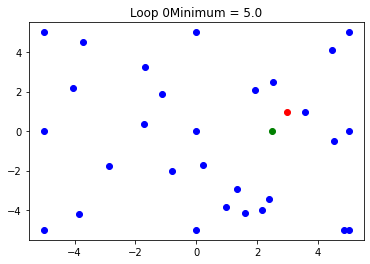

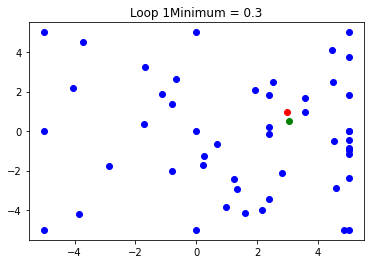

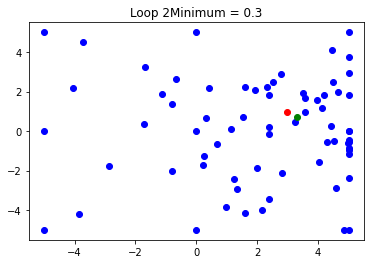

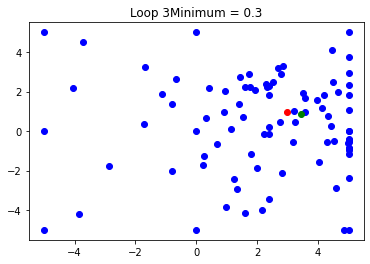

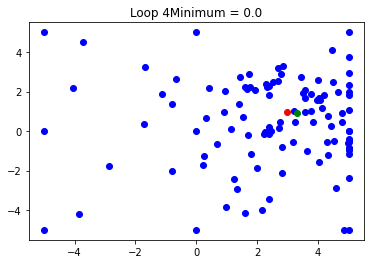

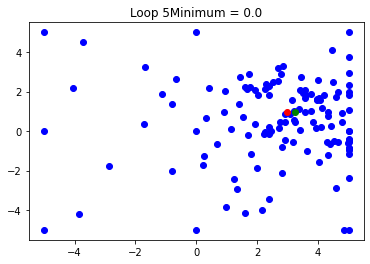

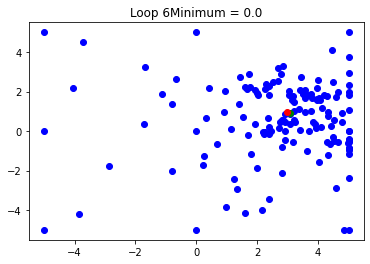

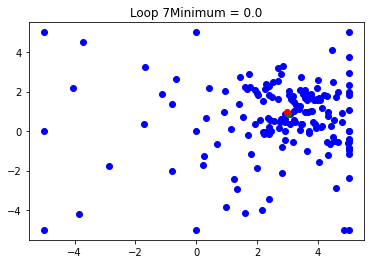

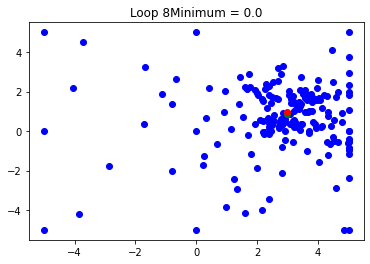

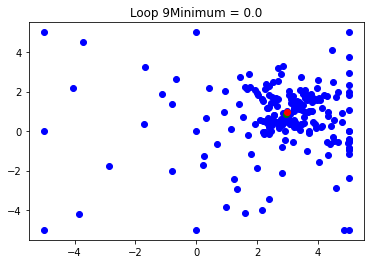

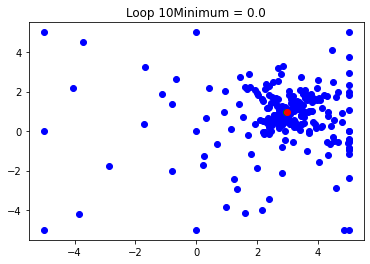

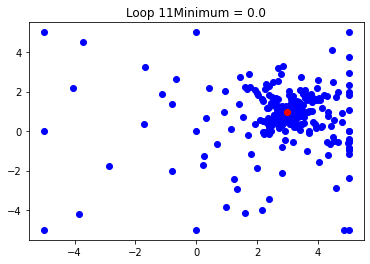

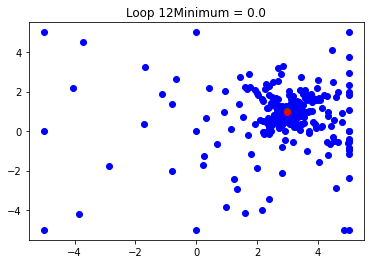

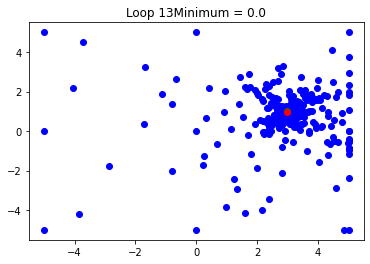

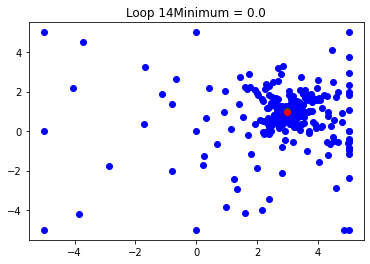

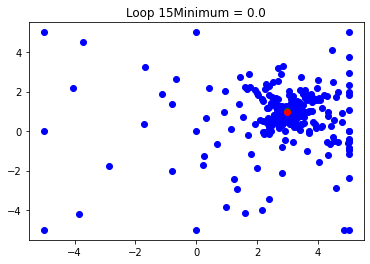

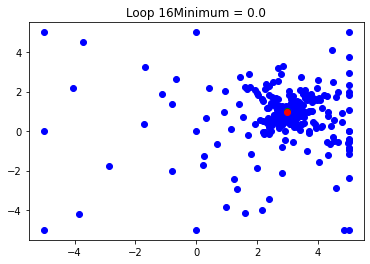

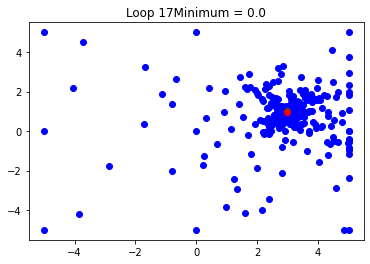

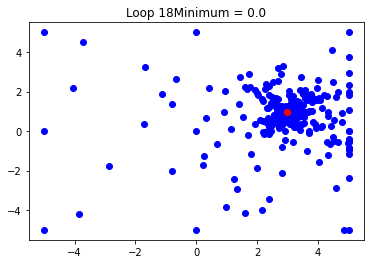

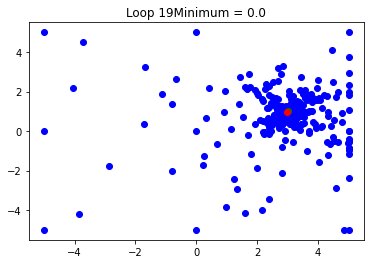

In [13]:
X,min_found, best_points=Optimtm(True)

In [14]:
# Print Minimum found
min=np.min(X.z.values)
print("Minimum found:")
print(X.iloc[np.argmin(X.z.values)])
#print("Theoretical Minimum : ")
#print(srf.iloc[np.argmin(srf.z)])


Minimum found:
x0    3.005436
x1    0.997448
z     0.000036
Name: n4, dtype: float64


In [15]:
def plot_convergence():
  plt.plot(Dom.idx,Dom['x0 C'],color='red')
  plt.plot(Dom.idx,Dom['x0 C']+Dom['x0 R'],color='blue')
  plt.plot(Dom.idx,Dom['x0 C']-Dom['x0 R'],color='blue')
  plt.title('X0')
  plt.show()
  plt.plot(Dom.idx,Dom['x1 C'],color='red')
  plt.plot(Dom.idx,Dom['x1 C']+Dom['x1 R'],color='blue')
  plt.plot(Dom.idx,Dom['x1 C']-Dom['x1 R'],color='blue')
  plt.title('X1')
  plt.show()
  #plt.plot(Dom['x0 C'],Dom['x1 C'],color='red')
  plt.plot(Dom['x0 C'],Dom['x1 C'])
  plt.ylabel('X1')
  plt.xlabel('X0')
  plt.show()
  return

In [16]:
plot_convergence()

NameError: ignored

In [18]:
# Using Hypertopt package
from hyperopt import hp, tpe, Trials, fmin,STATUS_OK

In [19]:
space = {
    'x0': hp.uniform('x0', x0range[0], x0range[1]),
    'x1': hp.uniform('x1', x1range[0], x1range[1])
}

In [20]:
def objective(params):
    """Objective function for Gradient Boosting Machine Hyperparameter Tuning"""
    x_vector=[params[i] for i in params]
    # Loss must be minimized
    loss = funct(x_vector)
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [21]:
# Algorithm
tpe_algorithm = tpe.suggest
# Trials object to track progress
bayes_trials = Trials()
MAX_EVALS = 49

# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials)
print(objective(best))

100%|██████████| 49/49 [00:00<00:00, 217.75it/s, best loss: 0.15533162701481515]
{'loss': 0.15533162701481515, 'params': {'x0': 2.6265670777472017, 'x1': 1.1260138071504493}, 'status': 'ok'}


In [22]:
bayes_trials

In [23]:
# Run the experiments
X,min_found, best_points=Optimtm(plot_steps=False)
print("Minimum found:",min_found, " at ",best_points)

Minimum :  0.002040608101214206
x0    2.979798
x1    0.959596
z     0.002041
Name: 7959, dtype: float64
Minimum found: 6.150877412897117e-05  at  x0    3.000990
x1    0.992220
z     0.000062
Name: n8, dtype: float64


In [ ]:
''